In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option("mode.chained_assignment", None)

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

## Idea for building the FIS model

 We collect the data for big-LITTLE core utilization and frequency, the memory at ondemand and the GPU util. I plan on setting all the values at 250 ms. So that it is in-tandem with what we decided. 

 Now the next steps are as follows :- 
 1. Sanity check -- check the correaltion of the utilization and the cost among all the three/four values
 2. Modeling -- build a conditional probability model for the likelihood of the others value; for eg in cluster 1 -- what is the likely value of say the CPU util when others are fuzzified
 3. The build a fuzzy arma model, using the weights and the linear regr value
 4. Then use predicition using that model --
 5. And finally predict the CPU usage say based on each cluster-- or sort of defuzzification
    

In [3]:
# Get the data --
utilData = pd.read_csv('UtilTRNS.csv')

In [4]:
utilData.head()

,Time,sCPU,cCost,sFreq,bCPU,bUtil,bFreq,Mem,mCost,mFreq,GPU,gCost,gFreq
0,1.700423e+09,sCPU,0,1400000,bCPU,0,2000000,Mem,0,825000000,GPU,0,600000000
1,1.700423e+09,sCPU,30,1400000,bCPU,0,2000000,Mem,1,825000000,GPU,0,600000000
2,1.700423e+09,sCPU,32,1400000,bCPU,0,2000000,Mem,0,825000000,GPU,0,600000000
3,1.700423e+09,sCPU,25,1400000,bCPU,0,2000000,Mem,1,825000000,GPU,0,600000000
4,1.700423e+09,sCPU,70,1400000,bCPU,0,2000000,Mem,3,825000000,GPU,0,600000000


## The code for creating a fuzzy values for the other aspects of the code --
1. Maybe use the history list to create a clustering of the values --
2. Add the two different values and then group them together.

<Axes: >

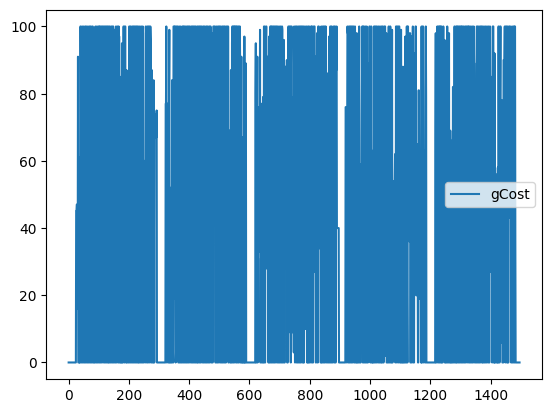

In [5]:
utilData[['gCost']].plot()

In [6]:
dCPU = utilData.cCost.to_numpy()
dMem = utilData.mCost.to_numpy()
dGPU = utilData.gCost.to_numpy()

In [7]:
fuzzyData = utilData[['mCost','gCost']].to_numpy()

In [8]:
fuzzyData_test = fuzzyData[:1000]

In [9]:
max(dCPU)

100

In [10]:
import skfuzzy as fuzz

In [11]:
n_cluster = 5

In [12]:
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(fuzzyData_test.T, n_cluster, 2, error=0.005, maxiter=1000, init=None)

In [13]:
p

37

In [14]:
fuzzyData.shape

(1497, 2)

In [15]:
u.shape

(5, 1000)

In [16]:
np.array(fuzzyData[1000]).T

array([ 9, 25])

In [17]:
ut,u0t,dt,jmt,pt,fpct = fuzz.cluster.cmeans_predict(np.array([fuzzyData[1000]]).T,cntr,2,error=0.005,maxiter=1000,init=None,seed=0)

In [18]:
ut

array([[0.01016255],
       [0.04126915],
       [0.09261841],
       [0.83717778],
       [0.0187721 ]])

In [19]:
import statsmodels.api as sm

In [20]:
X_train = sm.add_constant(fuzzyData_test)
X_train.shape

(1000, 3)

In [21]:
model0 = sm.WLS(dCPU[1:1001],X_train,weights=u[0])
model1 = sm.WLS(dCPU[1:1001],X_train,weights=u[1])
model2 = sm.WLS(dCPU[1:1001],X_train,weights=u[2])
model3 = sm.WLS(dCPU[1:1001],X_train,weights=u[3])
model4 = sm.WLS(dCPU[1:1001],X_train,weights=u[4])

In [22]:
result0 = model0.fit()
result1 = model1.fit()
result2 = model2.fit()
result3 = model3.fit()
result4 = model4.fit()

In [23]:
dCPU[1001]

36

In [24]:
fuzzyData[1000]

array([ 9, 25])

In [25]:
val = [0,0,0,0,0]

In [26]:
val[0]=result0.get_prediction([1,9,25]).predicted_mean

In [27]:
val[0]

array([42.81804733])

In [28]:
val[1] = result1.get_prediction([1,9,25]).predicted_mean

In [29]:
val[2] = result2.get_prediction([1,9,25]).predicted_mean

In [30]:
val[3] = result3.get_prediction([1,9,25]).predicted_mean

In [31]:
val[4]= result4.get_prediction([1,9,25]).predicted_mean

In [32]:
Out = [val[i]*ut[i] for i in range(5)]

In [33]:
sum(Out)

array([43.22384842])

## Get started with the coding part of fuzzy logic

In [34]:
# Get the training of the clusters and the model values
import skfuzzy as fuzz
import statsmodels.api as sm
import numpy as np
import pandas as pd
#------ Cluster related code -------

def train_Cluster(data, n_cluster = 5):
    print("The stats of the training data: features {} and size {}".format(len(data[0]), len(data)))
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, n_cluster, 2, error=0.005, maxiter=1000, init=None, seed = 0)
    print("The centroid values are \n {}".format(cntr))
    return cntr,u

def getCluster(data, cntr):
    print("The stats of the training data: shape".format(data.shape))
    ut,u0t,dt,jmt,pt,fpct = fuzz.cluster.cmeans_predict(data.T,cntr,2,error=0.005,maxiter=1000,init=None,seed=0)
    return ut

#------- Estimation related code ---------------
def get_shiftedData(data,shiftP=1):
    if shiftP < 1:
        print('Error!! The shift should be atleast one')
        return None
    df_temp = pd.DataFrame()
    df_temp['endog'] = data
    
    for i in range(1,shiftP+1):
        df_temp['endog_%d'% i] = df_temp['endog'].shift(i)

    df_out = df_temp.dropna()
    shiftedData = df_out.iloc[:,1:shiftP+1].values.reshape(-1,shiftP)
    return shiftedData
    
    
def train_AR(yData, xData, shiftP=3, weight=None):
    if len(yData) < 2*shiftP :
        print("Cannot train on small corupus")
        return None
    elif len(yData) != len(xData):
        print("Incorrect format of x and y values")
        return None
    #Now we train
    yShift = get_shiftedData(yData,shiftP)
    xShift = np.array(xData[shiftP-1:-1]) # We need to ensure that we are using the historical value while predicting the yVal
    newX = np.hstack((yShift,xShift))
    if weight is None:
        weight = np.ones(len(yData))
    weightShift = weight[shiftP:]
    #----- curate the data -----
    new_x = sm.add_constant(newX)
    ytrain = yData[shiftP:]
    model = sm.WLS(ytrain,new_x,weights=weightShift)
    result = model.fit()
    return result




def test_AR(model, yData, xData):
    xRun  = sm.add_constant(xData) # Adding the constant
    y_pred = model.get_prediction(xRun).predicted_mean
    y_act =  yData
    df_plot = pd.DataFrame()
    df_plot['Actual'] = yData
    df_plot['Predicted'] = y_pred
    df_plot[['Actual','Predicted']].plot()
    return

    

# Running the code using data modifications -- did not create a class. Draft version

In [35]:
# Get the training of the clusters and the model values
import skfuzzy as fuzz
import statsmodels.api as sm
import numpy as np
import pandas as pd
import math
#------ Cluster related code -------

def train_Cluster(data, n_cluster = 5):
    # print("The stats of the training data: features {} and size {}".format(len(data[0]), len(data)))
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, n_cluster, 2, error=0.005, maxiter=1000, init=None, seed = 0)
    # print("The centroid values are \n {}".format(cntr))
    return cntr,u

def getCluster(data, cntr):
    # print("The stats of the training data: shape".format(data.shape))
    ut,u0t,dt,jmt,pt,fpct = fuzz.cluster.cmeans_predict(data.T,cntr,2,error=0.005,maxiter=1000,init=None,seed=0)
    return ut

def getSingleCluster(data, cntr):
    ut,u0t,dt,jmt,pt,fpct = fuzz.cluster.cmeans_predict(np.array([data]).T,cntr,2,error=0.005,maxiter=1000,init=None,seed=0)
    return ut

    

def simple_train(yData, xData, weight=None):
    if weight is None:
        weight = np.ones(len(yData))

    new_x = sm.add_constant(xData)
    model = sm.WLS(yData,new_x,weights=weight)
    result = model.fit()
    return result

def simple_test(model , xData, yActual):
    # print("OldData",xData)
    newX = sm.add_constant(xData)
    # print("NData",newX)
    y_pred = model.get_prediction(newX).predicted_mean
    # df_plot = pd.DataFrame()
    # df_plot['Actual'] = yActual
    # df_plot['Predicted'] = y_pred
    # df_plot[['Actual','Predicted']].plot()
    return y_pred

def simple_test_single(model, xData):
    newX = [1.0]
    newX.extend(xData)
    y_pred = model.get_prediction(newX).predicted_mean
    return y_pred
    


from sklearn.metrics import mean_squared_error

# rms = mean_squared_error(y_actual, y_predicted, squared=False)
def rmse(predictions, targets):
    return mean_squared_error(targets, predictions, squared=False)

def highlight(indices,ax):
    i=0
    while i<len(indices):
        ax.axvspan(indices[i]-0.5, indices[i]+0.5, facecolor='red', edgecolor='none', alpha=.2)
        i+=1
    ax.legend(bbox_to_anchor=(1.0, 1.0))

In [36]:
# Some global variable setting
shiftAR = 8
shiftARX = 3
trainIDX = 4500
testIDX = 4500
N_CLUST = 5
N_HOPS = 10 # Future prediction window
SCALING_FACTOR = 1.2
cFreq = 'bFreq'#'sFreq'
mFreq = 'mFreq'
gFreq = 'gFreq'
# bFreq = 'bFreq'

endog = 'mCost'
exog = 'cCost'
exog1 = 'gCost'
rFreq = mFreq

### Test values IDX
TestIDX = 200 # How many steps to run
## Is there any other things.... to do
freq_dict = {}
freq_dict['gFreq'] = [177000000,266000000,350000000,420000000,480000000,600000000]
freq_dict['mFreq'] = [165000000,206000000,275000000,413000000,543000000,633000000,728000000,825000000]#,933000000]
# freq_dict['sFreq'] = [200000,300000,400000,500000,600000,700000,800000,900000,1000000,1100000,1200000,1300000,1400000]
freq_dict['bFreq'] = [200000,300000,400000,500000,600000,700000,800000,900000,1000000,1100000,1200000,1300000,1400000,1500000,1600000,1700000,1800000,1900000,2000000]
cost_list =['cCost','mCost','gCost']


In [37]:
## Getting the data ready for test train split and bucnch of experiments
# complete_data = pd.read_csv('UtilTRNS.csv')
# complete_data = pd.read_csv('UtilCopy.csv')
complete_data = pd.read_csv('./UtilTestFinal')
print(complete_data.shape)
complete_data.head()
# min(complete_data['bFreq'])

(8560, 7)


,Time,sUtil,sFreq,bUtil,bFreq,mUtil,mFreq
0,1.692295e+09,1,200000,8,300000,1,206000000
1,1.692295e+09,12,300000,24,600000,2,413000000
2,1.692295e+09,14,400000,24,600000,2,413000000
3,1.692295e+09,3,200000,7,300000,1,165000000
4,1.692295e+09,3,200000,19,500000,2,275000000


In [38]:
# For utilTestFinal
complete_data['cCost'] =  complete_data['bUtil']*complete_data['bFreq']/2000000
complete_data['mCost'] = complete_data['mUtil']*complete_data['mFreq']/825000000
# print(max(complete_data['mCost']))
complete_data['gCost'] = 0
complete_data['gFreq'] = 600000000

Testing the cost of:  mCost -- RMSE 2.9543821238309214


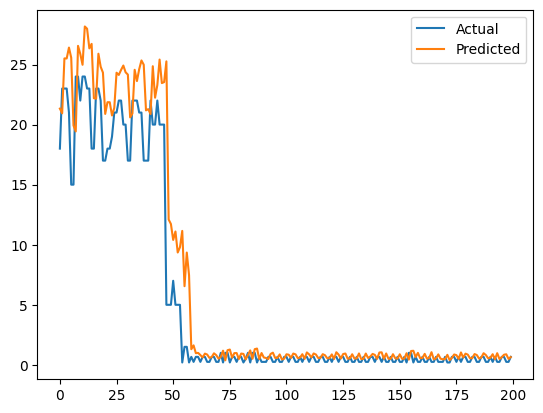

In [39]:
## Getting only the relevant columns
data_df = pd.DataFrame()
data_df = complete_data[[endog,exog,exog1]]
freq_df = pd.DataFrame()
freq_df = complete_data[[endog,exog,exog1,cFreq,mFreq,gFreq]]

# data_df.head()
# Creating Data for AR
for i in range(1,shiftAR+1):
    data_df['%s_%d'%(endog,i)] = data_df[endog].shift(i)
    freq_df['%s_%d'%(endog,i)] = freq_df[endog].shift(i)
data_df[exog] = data_df[exog].shift(1)
freq_df[exog] = freq_df[exog].shift(1)
for i in range(1,shiftARX+1):
    data_df['%s_%d'%(exog,i)] = data_df[exog].shift(i+1)   
    freq_df['%s_%d'%(exog,i)] = freq_df[exog].shift(i+1)   
data_df[exog1] = data_df[exog1].shift(1)
freq_df[exog1] = freq_df[exog1].shift(1)
for i in range(1,shiftARX+1):
    data_df['%s_%d'%(exog1,i)] = data_df[exog1].shift(i+1) 
    freq_df['%s_%d'%(exog1,i)] = freq_df[exog1].shift(i+1) 

# print("freq data len",len(data_df),len(data_df))
data_df = data_df.dropna() # Dropping NA
freq_df = freq_df.dropna() # Getting the Freq values without the NA
# print("checklen",len(data_df),len(freq_df))
# Train Test Divide
train_df = data_df.iloc[:trainIDX,:]
test_df = data_df.iloc[testIDX:,:]

test_freq_df = freq_df.iloc[testIDX:,:]
# print(test_df.head())
y_train = train_df.iloc[:,0].to_numpy()
x_train = train_df.iloc[:,1:].to_numpy()
y_test = test_df.iloc[:,0].to_numpy()
x_test = test_df.iloc[:,1:].to_numpy()
####### Trainign the data
cluster_center,prob = train_Cluster(x_train[:,:],n_cluster = N_CLUST)  #Cluster Indices

## Train the model
model = []
for i in range(N_CLUST):
    out_model = simple_train(y_train,x_train,weight = prob[i,:])
    model.append(out_model)

######## Testing the results

yPred = [ 0 for i in range(N_CLUST)]
probPred = getCluster(x_test[:TestIDX], cluster_center)

test_prob = getSingleCluster(x_test[0],cluster_center)
# print(test_prob.T[0])
# print(probPred.T[0])
## Test values in sigular way
ys_target = []
for id in range(TestIDX):
    prob_d = getSingleCluster(x_test[id],cluster_center).T[0]
    ys_t = []
    for i in range(N_CLUST):
        ys = simple_test_single(model[i],x_test[id])
        ys_t.append(ys*prob_d[i])
    ys_target.append(sum(ys_t)[0])

## Test the values
for i in range(N_CLUST):
    y_t = simple_test(model[i],x_test[:TestIDX], y_test[:TestIDX])
    yPred[i] = np.array(probPred[i,:])*np.array(y_t)


y_target = SCALING_FACTOR*sum(yPred)
y_out = y_test[:TestIDX]
print("Testing the cost of: ", endog, "-- RMSE", rmse(y_out,y_target))
# Plot the results
df_plot = pd.DataFrame()
df_plot['Actual'] = y_out
df_plot['Predicted'] = y_target
ax = df_plot[['Actual','Predicted']].plot()
ax.legend(bbox_to_anchor=(1.0, 1.0))
#### Done


In [40]:
# test_freq_df[[cFreq,mFreq,gFreq]] # This is how you get the frequency of the expected value of the test data

In [41]:

Y_pred = y_target
Y_act = y_out
FreqOut = test_freq_df[rFreq].iloc[:TestIDX].to_numpy()
DomCost = test_freq_df[cost_list].iloc[:TestIDX]

## Get the appropriate frequency of the resources -- and fractional energy savings.

In [42]:
'''
This function calculates the best frequency and the effective utilization at the estimated frequency
This also returns the estimated_frequency,effective_util and the actual_frequence 
'''
def get_freqAUtil(est_val,act_val,act_freq):
    eff_util_f = -1
    max_f = max(freq_dict[rFreq])
    est_freq = max_f
    m_freq_list = freq_dict[rFreq]
    for f in freq_dict[rFreq]:
        est_util_f = est_val*max_f/f
        if est_util_f <=100 or f == max_f:
            eff_util_f = act_val*max_f/f
            return f,eff_util_f,act_freq
    eff_util_f = -1
    return est_freq,eff_util_f,act_freq


# def get_freqAUtil(est_val,act_val,act_freq):
#     eff_util_f = -1
#     max_f = max(freq_dict[rFreq])
#     est_freq = max_f
#     my_freq_list = freq_dict[rFreq]
#     for fidx in range(len(my_freq_list)):
#         est_util_f = est_val*max_f/my_freq_list[fidx]
#         if est_util_f <=100 or my_freq_list[fidx] == max_f:
#             eff_util_f = act_val*max_f/my_freq_list[fidx]
#             return f,eff_util_f,act_freq
#     eff_util_f = -1
#     return est_freq,eff_util_f,act_freq
    
def dominant(idx):
    if DomCost[endog].iloc[idx] >= max(DomCost.iloc[idx].tolist()):
        return True
    else:
        False

        
    

    

In [43]:

pred_freq = []
act_freq = []
effective_y = []
for idx in range(len(Y_pred)):
    act_freq.append(FreqOut[idx])
    for v in freq_dict[rFreq]:
        val = Y_pred[idx]*max(freq_dict[rFreq])/v
        if val <= 100 or v == max(freq_dict[rFreq]):
            if val > 100 and v == max(freq_dict[rFreq]):
                pred_freq.append(min(v*val/100,v))
                effective_y.append(Y_act[idx]*max(freq_dict[rFreq])/v)
            else:
                pred_freq.append(v)
                effective_y.append(Y_act[idx]*max(freq_dict[rFreq])/v)

            break

error_pred = sum( i > 100 for i in effective_y )      
print("Number of prediction that will cause stalling in performance of ",endog," due to > 100 Util demand: ",error_pred)
print("Percentage error causing stall", error_pred * 100.0/ len(effective_y),"%")

#### Get the energy saving fraction
energy_ratio = 0
for idx in range(len(pred_freq)):
    energy_ratio += math.ceil(effective_y[idx]/100.)*(pred_freq[idx]/act_freq[idx])**2

energy_save =  1.0 - (energy_ratio / len(pred_freq))

print("Fractional energy saved by our approach : ", energy_save)
    
    

Number of prediction that will cause stalling in performance of  mCost  due to > 100 Util demand:  1
Percentage error causing stall 0.5 %
Fractional energy saved by our approach :  0.60429050191172


In [44]:
## Testing my code
pred_freq = []
act_freq = []
effective_y = []
dom_y = []
dom_eff_idx = []
for idx in range(len(Y_pred)):
    act_freq.append(FreqOut[idx])
    predF,Eff_Y,_ = get_freqAUtil(Y_pred[idx],Y_act[idx],FreqOut[idx])
    pred_freq.append(predF)
    effective_y.append(Eff_Y)
    dom_y.append(dominant(idx))
    if Eff_Y > 100 and dominant(idx) == True:
        dom_eff_idx.append(True)
    else:
        dom_eff_idx.append(False)
        
    
error_pred = sum( i > 100 for i in effective_y )
dom_pred = sum(i==True for i in dom_y)
eff_stall = sum(i==True for i in dom_eff_idx)

print("Number of prediction that will cause stalling in performance of ",endog," due to > 100 Util demand: ",error_pred)
print("Percentage error causing stall w/o dom resouce", error_pred * 100.0/ len(effective_y),"%")
print("Number of prediction that will cause effective stalling in performance of ",endog," being dom res and util>100 ",eff_stall)
print("Percentage error causing stall w dom resouce", eff_stall * 100.0/ len(effective_y),"%")


#### Get the energy saving fraction
energy_ratio = 0
for idx in range(len(pred_freq)):
    energy_ratio += math.ceil(effective_y[idx]/100.)*(pred_freq[idx]/act_freq[idx])**2

energy_save =  1.0 - (energy_ratio / len(pred_freq))

print("Fractional energy saved by our approach : ", energy_save)


Number of prediction that will cause stalling in performance of  mCost  due to > 100 Util demand:  1
Percentage error causing stall w/o dom resouce 0.5 %
Number of prediction that will cause effective stalling in performance of  mCost  being dom res and util>100  1
Percentage error causing stall w dom resouce 0.5 %
Fractional energy saved by our approach :  0.60429050191172


200


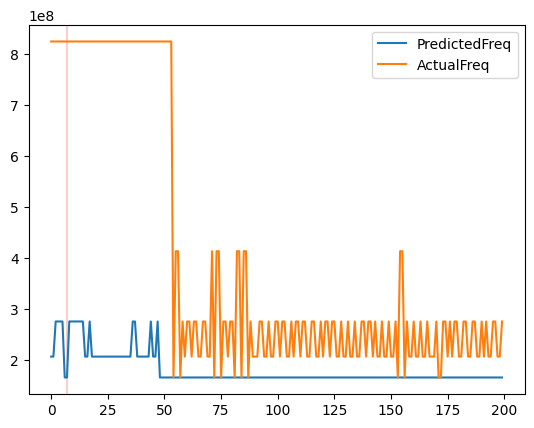

In [45]:
df_freq = pd.DataFrame()

df_freq['PredictedFreq'] = pred_freq
print(len(pred_freq))
df_freq['ActualFreq'] = act_freq
# df_freq['MaxFreq'] = max(freq_dict[rFreq])
df_freq['EffUtil'] = effective_y
df_freq['EffDomUtil'] = dom_eff_idx
df_freq['ActUtil'] = Y_act
# df_freq['MaxPoss'] = 100
ax = df_freq[['PredictedFreq','ActualFreq']].plot()
# highlight(df_freq[df_freq['EffUtil'] > 100].index, ax)
highlight(df_freq[df_freq['EffDomUtil'] == True].index, ax)

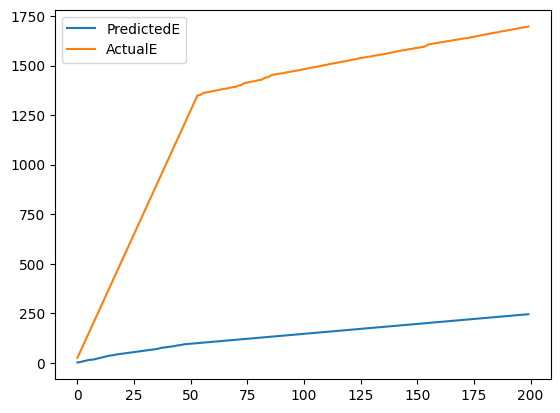

In [46]:
#Energy plot
pred_energy = []
act_energy = []
p_e = 0
a_e = 0
f_min = min(freq_dict[rFreq])
for idx in range(len(pred_freq)):
    p_e += (pred_freq[idx]/f_min)**2
    a_e += (act_freq[idx]/f_min)**2
    pred_energy.append(p_e)
    act_energy.append(a_e)

    
df_eng = pd.DataFrame()

df_eng['PredictedE'] = pred_energy

df_eng['ActualE'] = act_energy
# df_freq['MaxFreq'] = max(freq_dict[rFreq])
# df_freq['EffUtil'] = effective_y
# df_freq['ActUtil'] = Y_act
# df_freq['MaxPoss'] = 100
ax = df_eng[['PredictedE','ActualE']].plot()
# highlight(df_freq[df_freq['EffUtil'] > 100].index, ax)

In [47]:
#Some code for MPC -- which is not quite suitable for us 
def dlqr_calculate(A, B, Q, R):
    from scipy.linalg import solve_discrete_are, inv
    P = solve_discrete_are(A, B, Q, R)  #Riccati Solution 
    K = inv(B.T@P@B + R)@B.T@P@A    #K = (B^T P B + R)^-1 B^T P A 
    return K

# Transforming the prediction into multi-horizon prediction and optimization problem 

In [48]:
# Use multi-horizon prediciton and then check for the loss of accuracy with each increasing horizon. 
# Try to optimize the funciton we providde, may be we can add weight based on the know error
# Finally add the optimization values to check the output

In [49]:
def prediction(model,x,cluster):
    ## get cluster
    prob_d = getSingleCluster(x,cluster).T[0]
    y = []
    for i in range(N_CLUST):
        ys = simple_test_single(modelQ[i],xQ_test[id])
        y.append(ys*prob_d[i])
    my_pred = min(SCALING_FACTOR*sum(y)[0],100.0)
    return my_pred
    

Testing the cost of:  mCost -- RMSE 2.95438212383094
Testing the rmse hop:  1 -- RMSE 3.4696614020235788
Testing the rmse hop:  2 -- RMSE 3.751936207461949
Testing the rmse hop:  3 -- RMSE 4.033873959373308
Testing the rmse hop:  4 -- RMSE 4.236595914595116
Testing the rmse hop:  5 -- RMSE 4.429068717901739
Testing the rmse hop:  6 -- RMSE 4.685489794213518
Testing the rmse hop:  7 -- RMSE 4.91717277804446
Testing the rmse hop:  8 -- RMSE 5.15642697998275
Testing the rmse hop:  9 -- RMSE 5.43897209137929
Testing the rmse hop:  10 -- RMSE 5.755767610266525


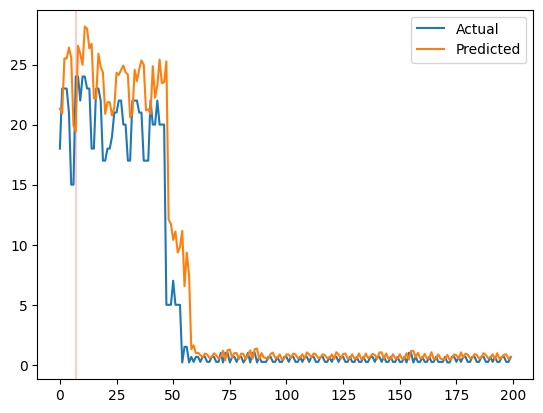

In [50]:
## Getting only the relevant columns
endog_df = pd.DataFrame()
exog_df = pd.DataFrame()
endog_df = complete_data[[endog]]
exog_df = complete_data[[exog,exog1]]
freqQ_df = pd.DataFrame()
freqQ_df = complete_data[[endog,exog,exog1,cFreq,mFreq,gFreq]]

# Creating Data for AR
for i in range(1,shiftAR+1):
    endog_df['%s_%d'%(endog,i)] = endog_df[endog].shift(i)
    freqQ_df['%s_%d'%(endog,i)] = freqQ_df[endog].shift(i)
    
exog_df[exog] = exog_df[exog].shift(1)
freqQ_df[exog] = freqQ_df[exog].shift(1)
for i in range(1,shiftARX+1):
    exog_df['%s_%d'%(exog,i)] = exog_df[exog].shift(i+1)   
    freqQ_df['%s_%d'%(exog,i)] = freqQ_df[exog].shift(i+1)   
exog_df[exog1] = exog_df[exog1].shift(1)
freqQ_df[exog1] = freqQ_df[exog1].shift(1)
for i in range(1,shiftARX+1):
    exog_df['%s_%d'%(exog1,i)] = exog_df[exog1].shift(i+1) 
    freqQ_df['%s_%d'%(exog1,i)] = freqQ_df[exog1].shift(i+1) 

# Merge the two data
combined_data = pd.concat([endog_df, exog_df], axis=1)

## All the exog and the endog data properly sorted
combined_data = combined_data.dropna() # Dropping NA
freqQ_df = freqQ_df.dropna() # Getting the Freq values without the NA

## Creating the data

trainQ_df = combined_data.iloc[:trainIDX,:]
testQ_df = combined_data.iloc[testIDX:,:]

testQ_freq_df = freqQ_df.iloc[testIDX:,:] # this is how you get the actual frequeny of the test data
# print(testQ_freq_df.head())
# print(test_df.head())
yQ_train = trainQ_df.iloc[:,0].to_numpy()
xQ_train = trainQ_df.iloc[:,1:].to_numpy()
yQ_test = testQ_df.iloc[:,0].to_numpy()
xQ_test = testQ_df.iloc[:,1:].to_numpy()


####### Trainign the data
clusterQ_center,probQ = train_Cluster(xQ_train[:,:],n_cluster = N_CLUST)  #Cluster Indices

## Train the model
modelQ = []
for i in range(N_CLUST):
    out_model = simple_train(yQ_train,xQ_train,weight = probQ[i,:])
    modelQ.append(out_model)

######## Testing the results
ys_target = [] ## Predicted values storage

########### Testing with hops .....
ys_hops = [[] for _ in range(N_HOPS)]

for id in range(TestIDX):
    predVal = prediction(modelQ,xQ_test[id],clusterQ_center)
    ys_target.append(predVal)
    ####### Doing the hops...
    my_endog = xQ_test[id][:shiftAR]
    myexog = xQ_test[id][shiftAR:]
    my_pred = predVal
    # if id == 10:
    #     print("endog",my_endog,"exog",myexog,"pred",my_pred)
    for h in range(N_HOPS):
        #update the endog
        x_d = [round(my_pred,1)]
        # added the prediciton and removed the prev
        x_d.extend(my_endog[:-1])
        ## Add the exog from original
        my_endog = x_d
        x_data = my_endog.copy()
        x_data.extend(xQ_test[id+h+1][shiftAR:])
        
        # if id==10:
        #     print("shifted",x_data,"pred",my_pred)
        my_pred = prediction(modelQ,x_data,clusterQ_center)
        ys_hops[h].append(my_pred)
        
            

yQ_out = yQ_test[:TestIDX]
fQ_Act = testQ_freq_df[rFreq].iloc[:TestIDX].to_numpy()
print("Testing the cost of: ", endog, "-- RMSE", rmse(yQ_out,ys_target))
## RMSE of NHOPS code
for h in range(N_HOPS):
    yh_out = yQ_test[h+1:TestIDX+h+1]
    print("Testing the rmse hop: ", h+1, "-- RMSE", rmse(yh_out,ys_hops[h]))

## create the 2D data for opt
Y_All = []
for i in range(len(ys_target)):
    val = [0.0]*(N_HOPS+1)
    for j in range(N_HOPS+1):
        if j == 0:
            val[j] = ys_target[i]
        else:
            val[j] = ys_hops[j-1][i]
    Y_All.append(val)
        
    
# Plot the results
df_plot = pd.DataFrame()
df_plot['Actual'] = yQ_out

df_plot['Predicted'] = ys_target
ax = df_plot[['Actual','Predicted']].plot()
ax.legend(bbox_to_anchor=(1.0, 1.0))
#### Done
# highlight(df_freq[df_freq['EffUtil'] > 100].index, ax)
highlight(df_freq[df_freq['EffDomUtil'] == True].index, ax)

In [51]:
df_freq[df_freq['EffUtil'] > 100].index

Index([7], dtype='int64')

In [52]:
import numpy as np
import cvxopt as opt
from cvxopt import matrix, spmatrix, sparse
from cvxopt.solvers import qp, options
from cvxopt import blas
opt.solvers.options['show_progress'] = False

FList = freq_dict[rFreq]
f_max = max(FList)
f_min = min(FList)
n = 3
C_e = 1
C_l = 0.2
ref = 80
OPT_FREQ = []

for id in range(len(Y_All)):
    ConstQ = (C_e + C_l * (ref/f_max))
    Q = ConstQ * np.identity(n)
    Q = 0.5 * (Q + Q.T)
    r = []
    G = -(1.0/f_min) * np.identity(n)
    # print(Q)
    # Getting the h vector
    h = []
    for i in range(n):
        var_lims = -(1.0/f_min) * max(Y_All[id][i]*f_max/100.0 , f_min)
        r_val = -1 * C_l* (ref/f_max)*Y_All[id][i]
        r.append(r_val)
        h.append(var_lims)
    # r = matrix(r)
    sol = qp(matrix(Q), matrix(r), matrix(G),matrix(h))
    OPT_FREQ.append(sol['x'][0])
    # print(sol['x'], len(sol['x']))


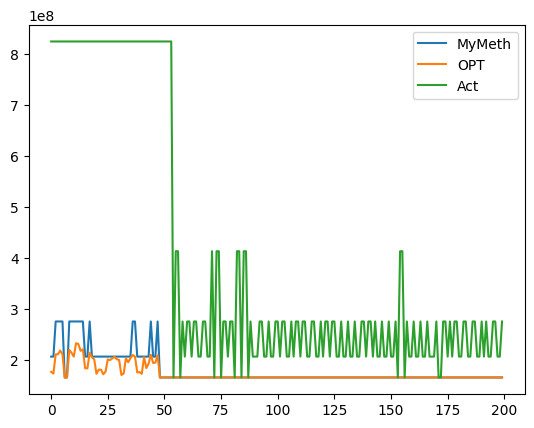

In [53]:
df_fplot = pd.DataFrame()
df_fplot['MyMeth'] = pred_freq
df_fplot['OPT'] = OPT_FREQ
df_fplot['Act'] = fQ_Act
ax = df_fplot[['MyMeth','OPT','Act']].plot()
ax.legend(bbox_to_anchor=(1.0, 1.0))

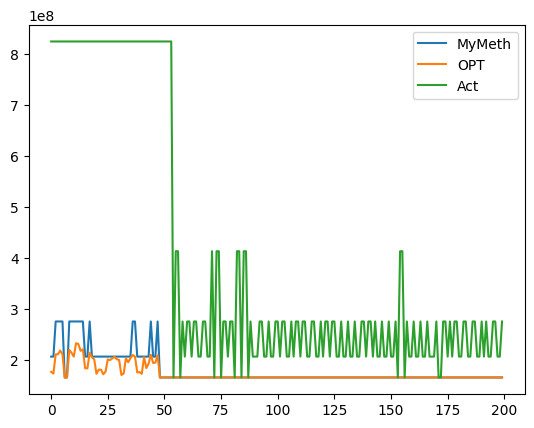

In [54]:
df_fplot = pd.DataFrame()
df_fplot['MyMeth'] = pred_freq
df_fplot['OPT'] = OPT_FREQ
df_fplot['Act'] = act_freq
ax = df_fplot[['MyMeth','OPT','Act']].plot()
ax.legend(bbox_to_anchor=(1.0, 1.0))

In [55]:
# act1_freq = []
# effective1_y = []
# for idx in range(len(Y_pred)):
#     act1_freq.append(FreqOut[idx])
#     effective1_y.append(Y_act[idx]*max(freq_dict[rFreq])/OPT_)


# error_pred = sum( i > 100 for i in effective_y )      
# print("Number of prediction that will cause stalling in performance of ",endog," due to > 100 Util demand: ",error_pred)
# print("Percentage error causing stall", error_pred * 100.0/ len(effective_y),"%")

# #### Get the energy saving fraction
# energy_ratio = 0
# for idx in range(len(pred_freq)):
#     energy_ratio += math.ceil(effective_y[idx]/100.)*(pred_freq[idx]/act_freq[idx])**2

# energy_save =  1.0 - (energy_ratio / len(pred_freq))

# print("Fractional energy saved by our approach : ", energy_save)
    